### Links:
* http://www.danvk.org/2015/01/07/finding-blocks-of-text-in-an-image-using-python-opencv-and-numpy.html
* http://felix.abecassis.me/2011/10/opencv-rotation-deskewing/

In [1]:
import sys; sys.path.append('scripts/')

In [2]:
from doc2text import *
from helpers import *
from curriedCv import *

In [3]:
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 12, 9 

---

# а

In [4]:
def plot_letter_line_finding(image):
    x = image.copy().astype(np.int32)
    x -= 1
    x[x > 0] = 0
    x = np.abs(x)
    bars = pd.Series(np.sum(x, axis=1))
    bars[bars < bars.mean()] = -1
    bars[bars > 0] = 1
    cb = np.cumsum(bars)
    cb.plot();

In [5]:
def my_pipe(path):
    img = load(path)
    result = pipe(img, 
                  descew,

                  dog, 
                  negate, 
                  normalize, 
                  gaussian, 
                  level(black=0.0, white=1, gamma=1), 
                  float_to_uint8, 
                  to_gray,
                  threshold
                 )
    show(img, result)
    plot_letter_line_finding(result);

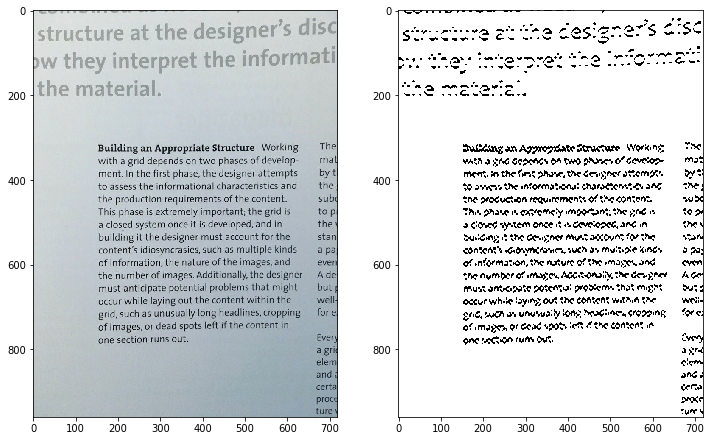

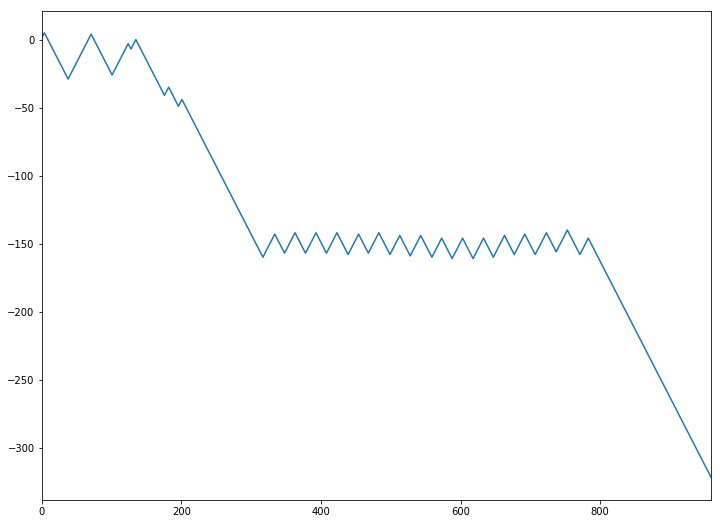

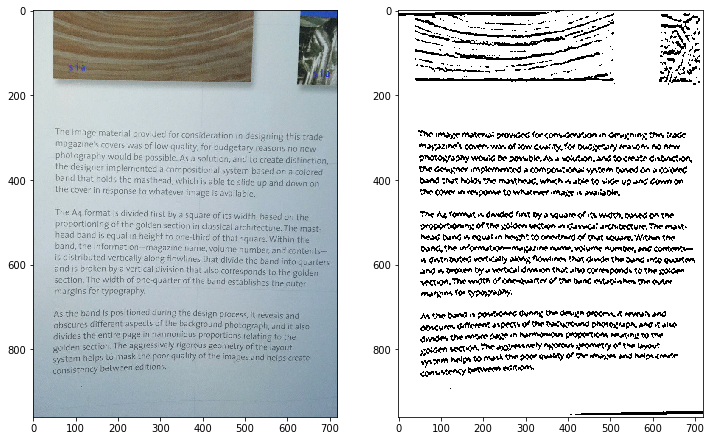

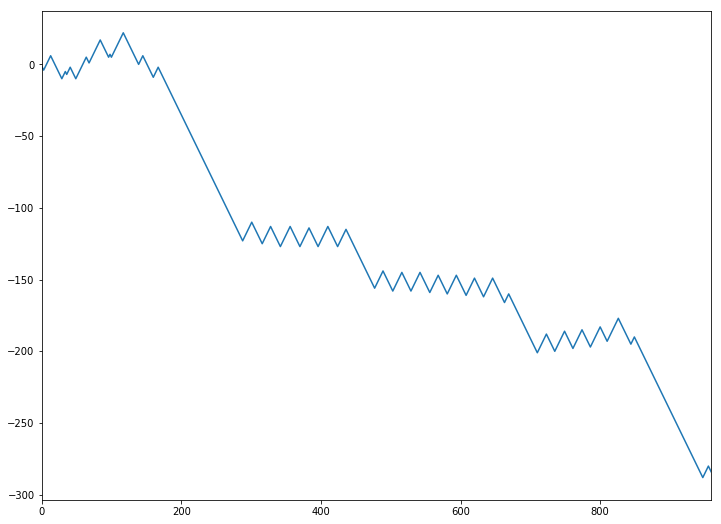

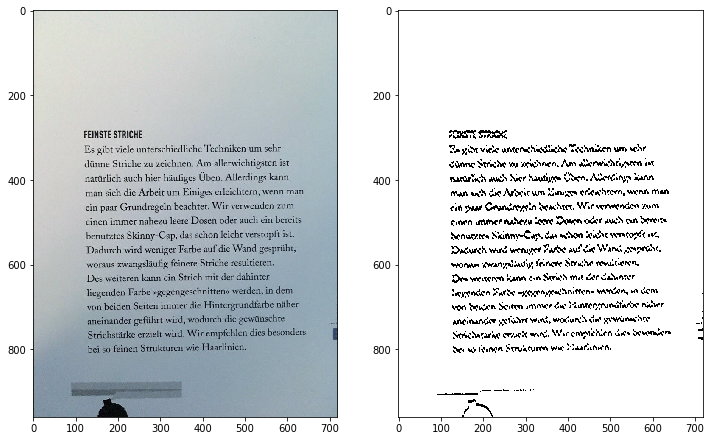

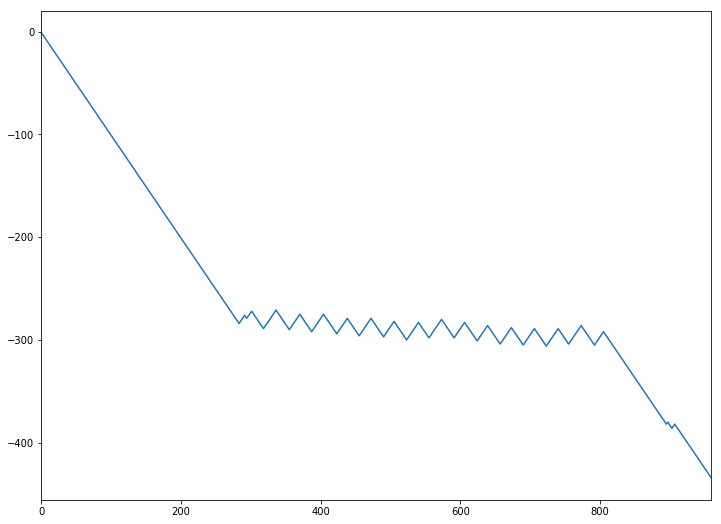

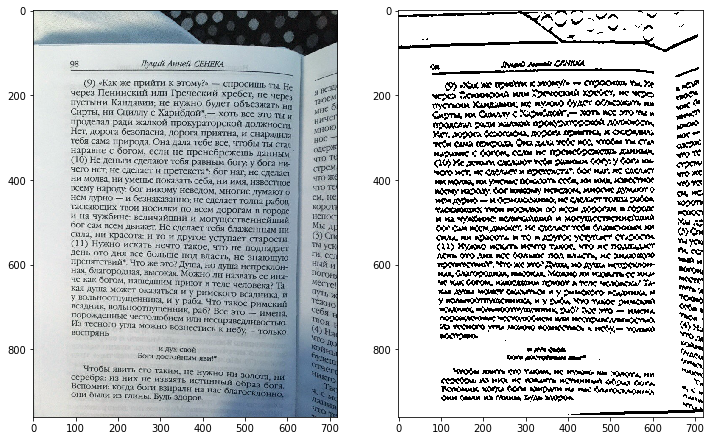

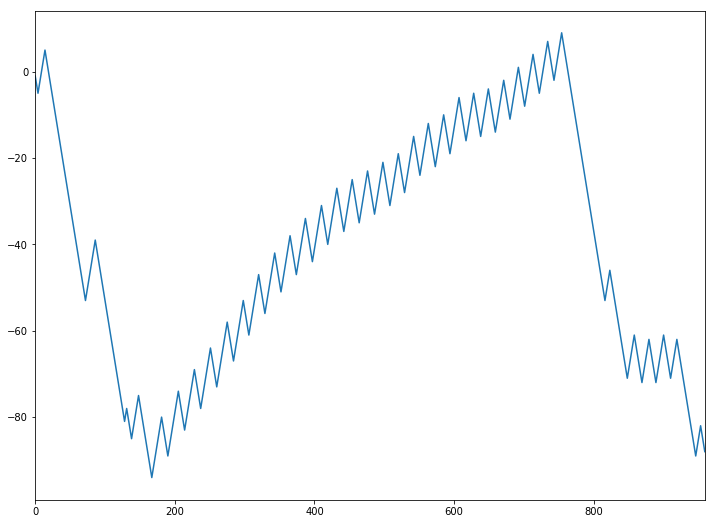

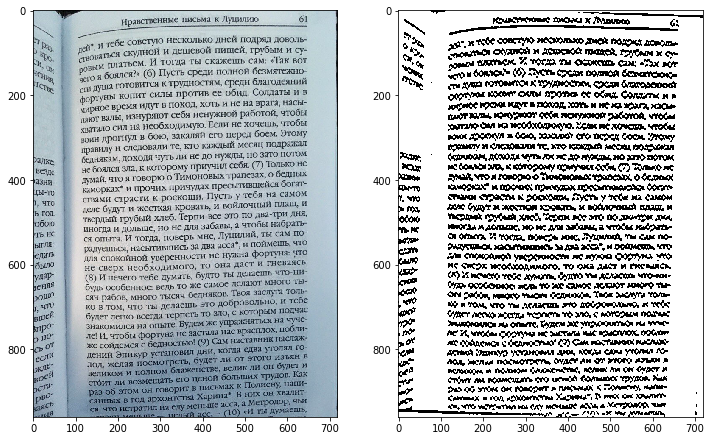

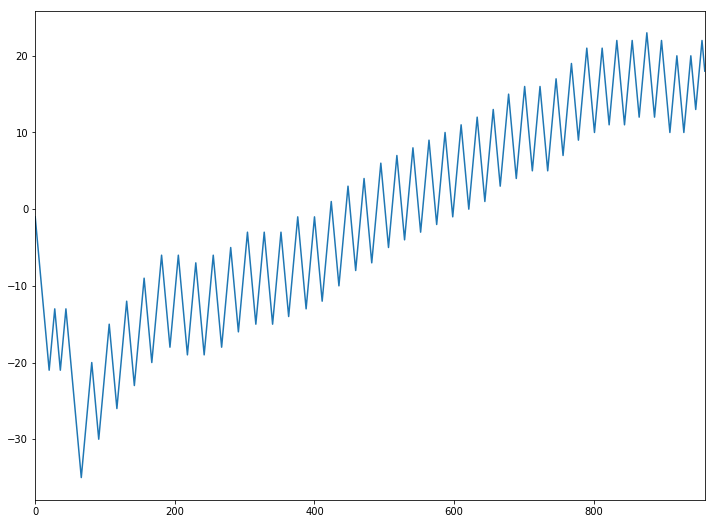

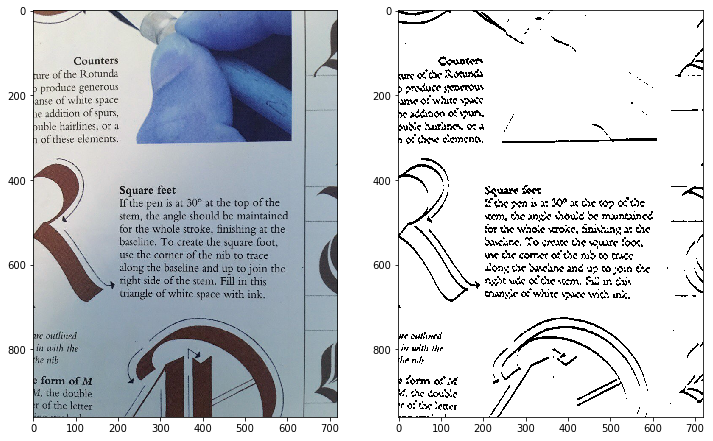

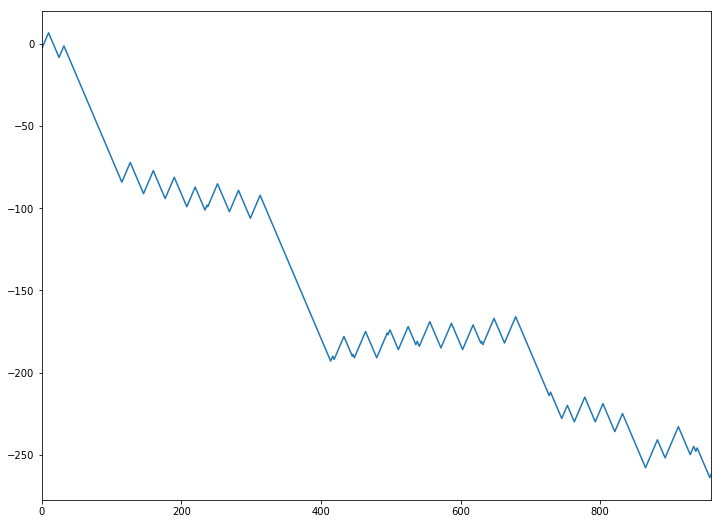

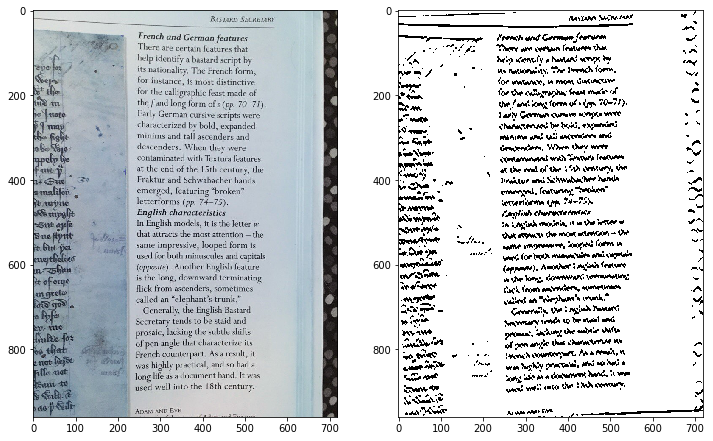

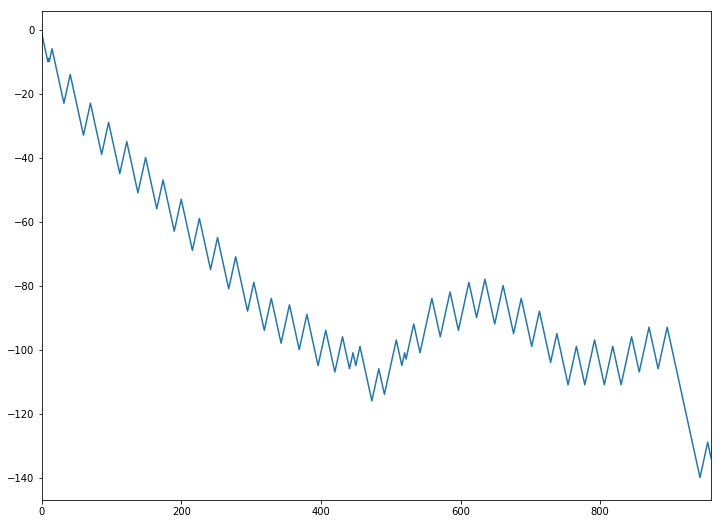

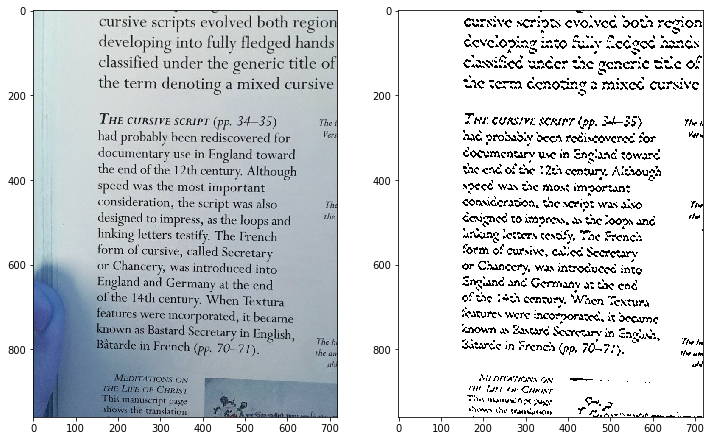

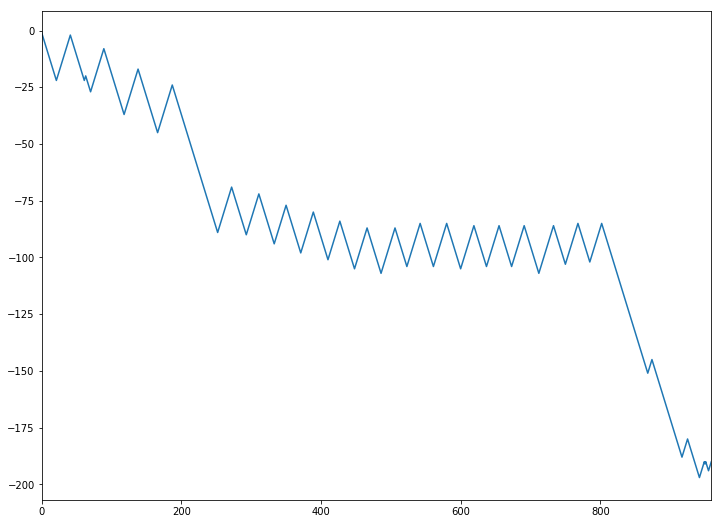

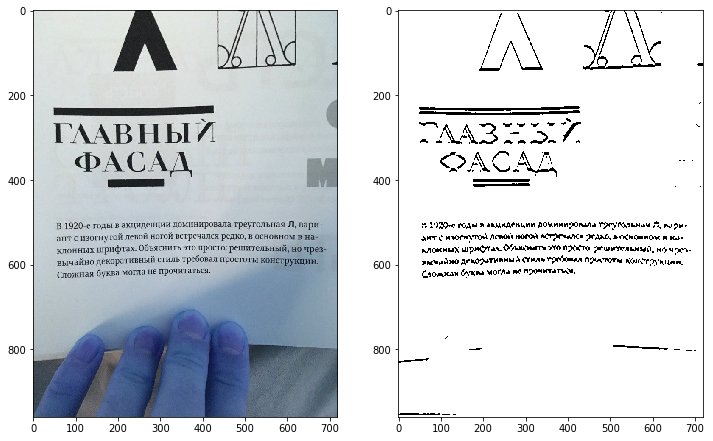

[None, None, None, None, None, None, None, None, None]

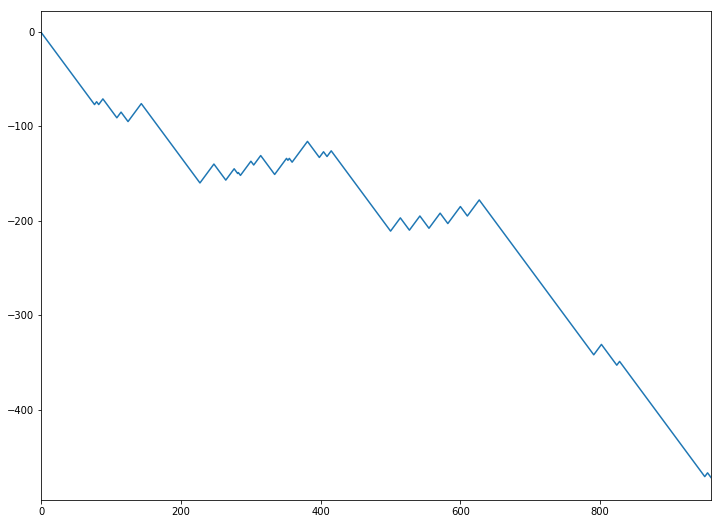

In [6]:
[my_pipe('data/{}.jpg'.format(x)) for x in range(1,10)]

# Line height

In [33]:
from scipy.signal import argrelextrema

In [6]:
def pixel_bars(image, axis=1):
    a = image.copy()
    a[a > 0]= 1
    return np.sum(a, axis=axis)

In [7]:
def plot_with_minima(horizontal=True):
    plt.figure(figsize=(8,5))
    f = plt.barh if horizontal else plt.bar
    f(range(len(bars)), bars, color='black')
#     plt.axvline(x=average)

In [36]:
bars = pixel_bars(result, axis=1)
minima_i = argrelextrema(bars, np.less)[0]
minima  = np.array([bars[i] for i in minima_i])
local_minima = zip(minima_i, minima)
average = (np.max(minima) - np.min(minima)) / 2.0 + np.min(minima)

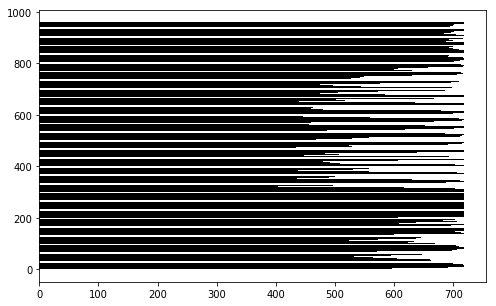

In [37]:
plot_with_minima(horizontal=True)

In [38]:
best = [x for x in local_minima if x[1] < average]

In [39]:
distances = [best[i][0]-best[i-1][0] for i in range(1, len(best))]

In [40]:
line_height = np.median(distances)
line_height

20.5

In [41]:
lh = int(line_height) + 1 if np.mean(distances) > line_height else 0

In [42]:
a = to_color(result.copy())

In [43]:
for i in range(int(a.shape[0] // line_height)):
    cv2.line(a, (0, i*lh), (a.shape[1], i*lh), (255,0,0))

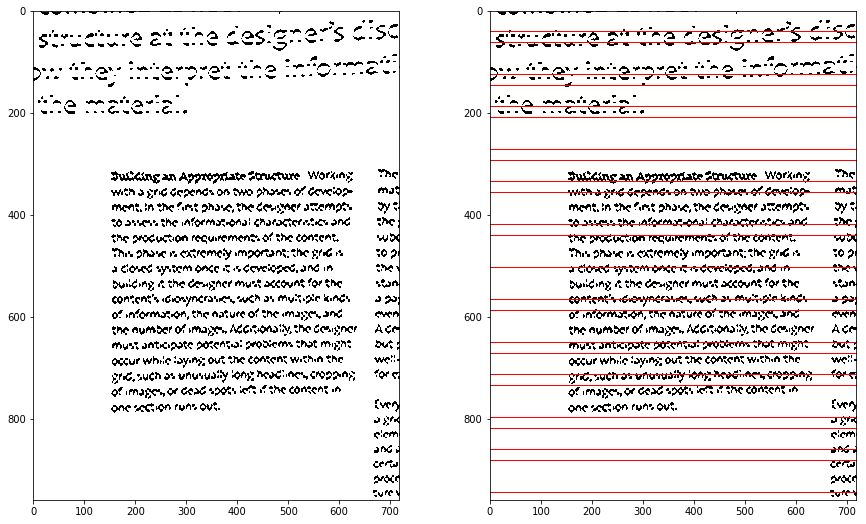

In [44]:
show(result, a)

In [45]:
cv2.imwrite('123.png', a)

True

# Blocks of text and aglomerative clustering

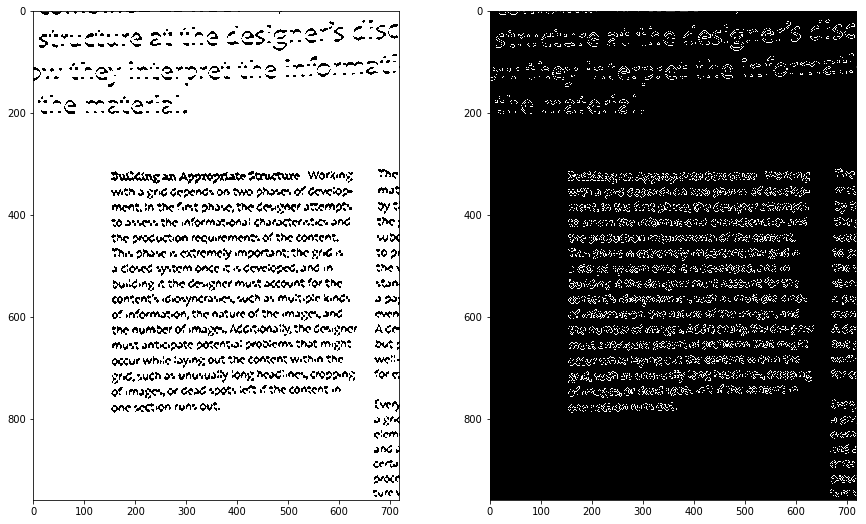

In [46]:
edges = pipe(result, 
             canny
            )

show(result, edges)

In [47]:
count_image, cntrs, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [48]:
len (cntrs)

1701

In [56]:
def draw_countours(gde, cnts, indices):
    a = gde.copy()
    for c in indices:
        a = cv2.drawContours(a, cnts, c, (120,200,0), 3)
    return a

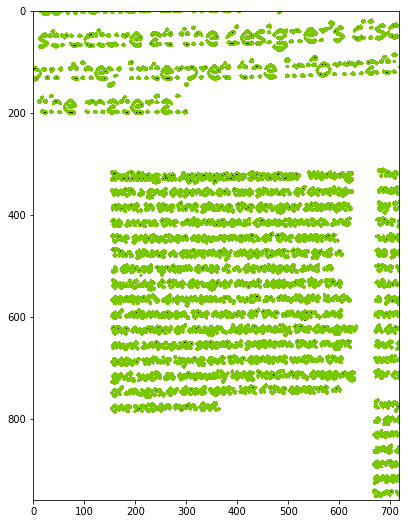

In [57]:
canvas = to_color(result)
show(draw_countours(canvas, cntrs, list(range(len(cntrs)))))

In [63]:
import seaborn as sns

In [58]:
rects = [cv2.boundingRect(x) for x in cntrs]

In [85]:
df = pd.DataFrame(data=rects, columns=['x', 'y', 'width', 'height'])
df['shapes'] = df.width * df.height
df['contour'] = cntrs

In [86]:
df.head()

,x,y,width,height,shapes,contour
0,669,950,5,5,25,"[[[671, 950]], [[673, 952]], [[673, 953]], [[6..."
1,669,950,1,1,1,"[[[669, 950]]]"
2,691,945,7,7,49,"[[[692, 945]], [[692, 946]], [[691, 947]], [[6..."
3,675,944,11,11,121,"[[[676, 944]], [[676, 945]], [[675, 946]], [[6..."
4,711,941,8,11,88,"[[[712, 941]], [[711, 942]], [[711, 944]], [[7..."


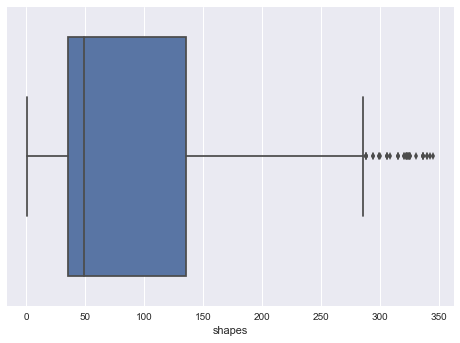

In [95]:
ax = sns.boxplot(df.shapes)

In [91]:
def check_outliers(a, outlier_constant=1.5):
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlier_constant
    lower, upper = (lower_quartile - IQR, upper_quartile + IQR)
    return [x >= lower and x <= upper for x in a]

In [93]:
df = df[check_outliers(df.shapes)]

In [94]:
df.shape

(1543, 6)

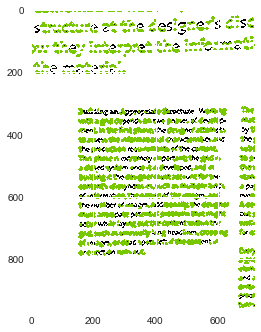

In [98]:
canvas = to_color(result)
show(draw_countours(canvas, df.contour, list(range(len(df.contour)))))

In [25]:
def tr_rect(rect):
    hw = rect[-2]/2
    hh = rect[-1]/2
    return (rect[0] + hw, rect[1] + hh)

In [26]:
centers = [tr_rect(x) for x in rects]

In [27]:
df = pd.DataFrame(data=centers, columns=['x', 'y'])

In [29]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
ag = AgglomerativeClustering(compute_full_tree=True, n_clusters=len (cntrs))

In [31]:
ag.fit(df);

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [33]:
ls = linkage(df)

In [34]:
# augmented_dendrogram(ls)

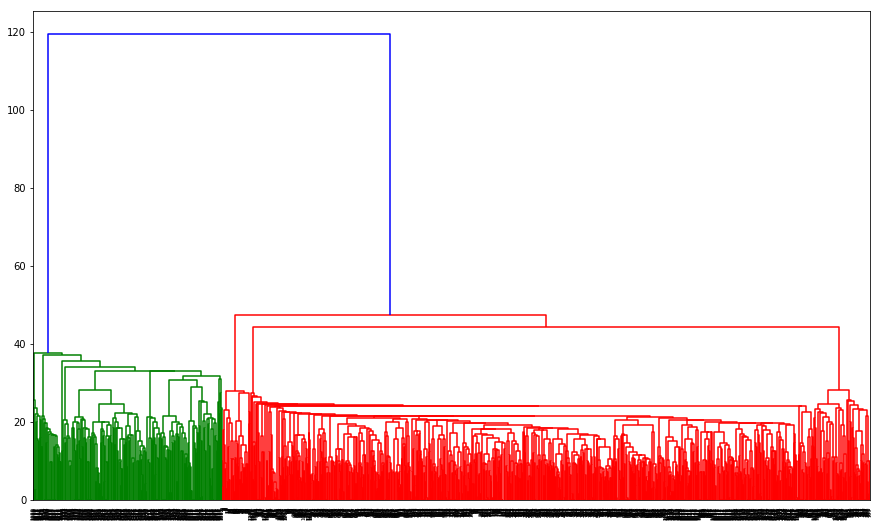

In [37]:
d = dendrogram(ls)

In [38]:
squares = [x[-2]*x[-1] for x in rects]

In [39]:
m = max(squares)
squares.remove(m)

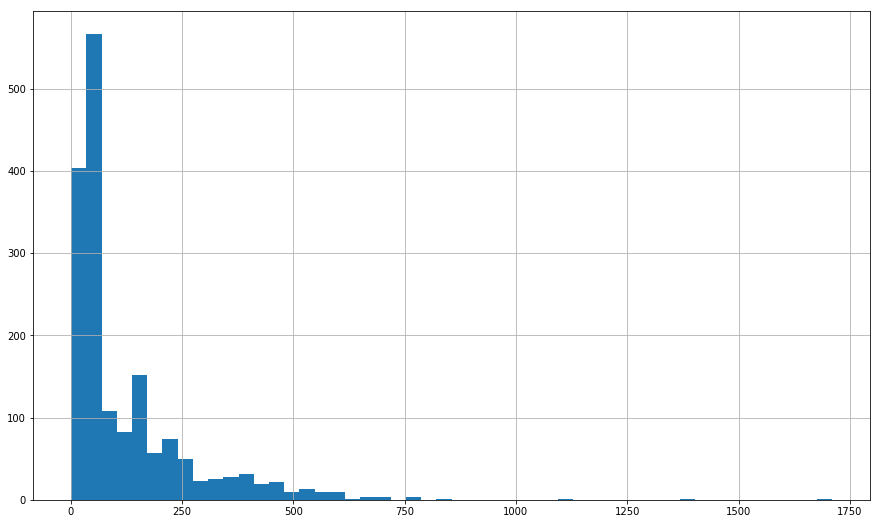

In [40]:
h = pd.Series(squares).hist(bins=50);

In [41]:
h = np.histogram(squares)